# Лабораторная работа 3

Задание: Повторить эксперимент применения дифференциального рендеринга для восстановления параметров 3D сцены по исходному изображению человеческого лица (Моны Лизы)

In [35]:
!python --version

Python 3.8.18


In [2]:
!sudo apt-get update -y
!sudo apt-get install python3.8
from IPython.display import clear_output
clear_output()
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --config python3
!python3 --version
!sudo apt install python3-pip
!sudo apt install python3.8-distutils

update-alternatives: using /usr/bin/python3.8 to provide /usr/bin/python3 (python3) in auto mode
There is only one alternative in link group python3 (providing /usr/bin/python3): /usr/bin/python3.8
Nothing to configure.
Python 3.8.18
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python3-pip python3-setuptools python3-wheel
0 upgraded, 3 newly installed, 0 to remove and 27 not upgraded.
Need to get 1,677 kB of archives.
After this operation, 8,967 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-setuptools all 59.6.0-1.2ubuntu0.22.04.1 [339 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 python3-wheel all 0.37.1-2ubuntu0.22.04.1 [32.0 kB]
Get:3 http://archive.ubuntu.com/ub

In [3]:
%%capture no-display
import sys

path_conda = !which conda

if len(path_conda) == 0:
    %env PYTHONPATH = # /env/python

    !wget https://repo.anaconda.com/miniconda/Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
    !chmod +x Miniconda3-py38_23.11.0-2-Linux-x86_64.sh
    !./Miniconda3-py38_23.11.0-2-Linux-x86_64.sh -b -f -p /usr/local Y
    !conda update conda

    sys.path.append('/usr/local/lib/python3.8/site-packages')

    !conda create -y -n myenv python=3.8

In [4]:
!which python

/usr/local/bin/python


In [5]:
%%bash
source activate myenv

python --version
conda --version

Python 3.8.18
conda 23.11.0


In [6]:
%%capture no-display
%%bash
source activate myenv

pip install torch torchvision numpy
pip install redner-gpu
pip install h5py matplotlib urllib3 ipython pillow

In [7]:
%%bash
source activate myenv
python

import pyredner

print('Current device:', pyredner.get_device())

Current device: cpu


In [8]:
import os

import matplotlib.pyplot as plt

In [9]:
join_path = lambda x: os.path.join('/content/', x)

In [11]:
%%bash
source activate myenv
python

import torch
import pyredner
import h5py
import urllib
import time
import os

from IPython.display import HTML, display, clear_output
from matplotlib import animation
from PIL import Image


join_path = lambda x: os.path.join('/content/', x)


'''
Загрузка датасета лиц
'''

print('1. Loading the Basel face model')

with h5py.File(r'/content/model2017-1_bfm_nomouth.h5', 'r') as hf:
    shape_mean = torch.tensor(
        hf['shape/model/mean'],
        device = pyredner.get_device()
    )

    shape_basis = torch.tensor(
        hf['shape/model/pcaBasis'], # базисный вектор формы
        device = pyredner.get_device()
    )

    triangle_list = torch.tensor(
        hf['shape/representer/cells'],
        device = pyredner.get_device()
    )

    color_mean = torch.tensor(
        hf['color/model/mean'],
        device = pyredner.get_device()
    )

    color_basis = torch.tensor(
        hf['color/model/pcaBasis'], # базисный вектор цвета
        device = pyredner.get_device()
    )


'''
Создание модели, которая на вход будет принимать векторы скрытого представления \
цвета и формы лица, параметры камеры и освещения в сцене, а на выходе будет \
генерировать отрендеренное изображение
'''

print('2. Getting average face geometry')

indices = triangle_list.permute(1, 0).contiguous() # хранит геометрию усредненного лица в форме полигональной модели


print('3. Creating the model')

def model(cam_pos,
          cam_look_at,
          shape_coeffs,
          color_coeffs,
          ambient_color,
          dir_light_intensity):

    vertices = (shape_mean + shape_basis @ shape_coeffs).view(-1, 3)
    normals = pyredner.compute_vertex_normal(vertices, indices)
    colors = (color_mean + color_basis @ color_coeffs).view(-1, 3)

    m = pyredner.Material(use_vertex_color = True)

    obj = pyredner.Object(
        vertices=vertices,
        indices=indices,
        normals=normals,
        material=m,
        colors=colors
    )

    cam = pyredner.Camera(
        position=cam_pos,
        # Center of the vertices
        look_at=cam_look_at,
        up=torch.tensor([0.0, 1.0, 0.0]),
        fov=torch.tensor([45.0]),
        resolution=(256, 256)
    )

    scene = pyredner.Scene(camera=cam, objects=[obj])

    ambient_light = pyredner.AmbientLight(ambient_color)
    dir_light = pyredner.DirectionalLight(torch.tensor([0.0, 0.0, -1.0]), dir_light_intensity)

    img = pyredner.render_deferred(scene=scene, lights=[ambient_light, dir_light])

    return img


'''
Задание первоначальных параметров освещения и позиции камеры и применение модели
'''

print('4. Creating params')

cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277])
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918])

img = model(
    cam_pos,
    cam_look_at,
    torch.zeros(199, device=pyredner.get_device()),
    torch.zeros(199, device=pyredner.get_device()),
    torch.ones(3),
    torch.zeros(3)
)

torch.save(torch.pow(img, 1.0/2.2).cpu(), '/content/init.pt')


'''
Загрузка целевого изображения, параметры которого нужно восстановить
'''

face_url = 'https://raw.githubusercontent.com/BachiLi/redner/master/tutorials/mona-lisa-cropped-256.png'

urllib.request.urlretrieve(face_url, 'target.png')
target = pyredner.imread('target.png').to(pyredner.get_device())

torch.save(torch.pow(target, 1.0 / 2.2).cpu(), '/content/target.pt')


'''
Зададим начальные значения параметров, которые будем пытаться восстановить для целевой картины.
'''

# Set requires_grad=True since we want to optimize them later
cam_pos = torch.tensor([-0.2697, -5.7891, 373.9277], requires_grad=True)
cam_look_at = torch.tensor([-0.2697, -5.7891, 54.7918], requires_grad=True)
shape_coeffs = torch.zeros(199, device=pyredner.get_device(), requires_grad=True)
color_coeffs = torch.zeros(199, device=pyredner.get_device(), requires_grad=True)
ambient_color = torch.ones(3, device=pyredner.get_device(), requires_grad=True)
dir_light_intensity = torch.zeros(3, device=pyredner.get_device(), requires_grad=True)

# Use two different optimizers for different learning rates
optimizer = torch.optim.Adam([
    shape_coeffs,
    color_coeffs,
    ambient_color,
    dir_light_intensity
], lr=0.1)

cam_optimizer = torch.optim.Adam([cam_pos, cam_look_at], lr=0.5)




imgs, losses = [], []

# Run 500 Adam iterations
num_iters = 500

for t in range(num_iters):
    optimizer.zero_grad()
    cam_optimizer.zero_grad()

    img = model(cam_pos, cam_look_at, shape_coeffs, color_coeffs, ambient_color, dir_light_intensity)

    # Compute the loss function. Here it is L2 plus a regularization
    # term to avoid coefficients to be too far from zero.
    # Both img and target are in linear color space,
    # so no gamma correction is needed.

    loss = (img - target).pow(2).mean()
    loss = loss + 0.0001 * shape_coeffs.pow(2).mean() + 0.001 * color_coeffs.pow(2).mean()
    loss.backward()

    optimizer.step()
    cam_optimizer.step()

    ambient_color.data.clamp_(0.0)
    dir_light_intensity.data.clamp_(0.0)

    losses.append(loss.data.item())

    # Only store images every 10th iterations
    if t % 10 == 0:
        # Record the Gamma corrected image
        imgs.append(torch.pow(img.data, 1.0 / 2.2).cpu())


torch.save(imgs, 'imgs.pt')

with open('losses.txt', 'w+') as file:
    for loss in losses:
        file.write('%s\n' %loss)

1. Loading the Basel face model
2. Getting average face geometry
3. Creating the model
4. Creating params
Scene construction, time: 0.04288 s
Forward pass, time: 0.17371 s
Scene construction, time: 0.12862 s
Forward pass, time: 0.21633 s
Backward pass, time: 1.96325 s
Scene construction, time: 0.13302 s
Forward pass, time: 0.15166 s
Backward pass, time: 1.57575 s
Scene construction, time: 0.13051 s
Forward pass, time: 0.14675 s
Backward pass, time: 1.53014 s
Scene construction, time: 0.12599 s
Forward pass, time: 0.16564 s
Backward pass, time: 2.67885 s
Scene construction, time: 0.22172 s
Forward pass, time: 0.21236 s
Backward pass, time: 1.63444 s
Scene construction, time: 0.12610 s
Forward pass, time: 0.14090 s
Backward pass, time: 1.49503 s
Scene construction, time: 0.12724 s
Forward pass, time: 0.14204 s
Backward pass, time: 1.52857 s
Scene construction, time: 0.12430 s
Forward pass, time: 0.13621 s
Backward pass, time: 1.52274 s
Scene construction, time: 0.12499 s
Forward pass, ti

<stdin>:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)


In [25]:
import matplotlib.pyplot as plt
import torch
import h5py
import urllib

In [26]:
init = torch.load('/content/init.pt')
target = torch.load('/content/target.pt')

In [27]:
imgs = torch.load('/content/imgs.pt')

In [28]:
with open('/content/losses.txt', 'rb') as file:
    losses = [float(line.strip()) for line in file]

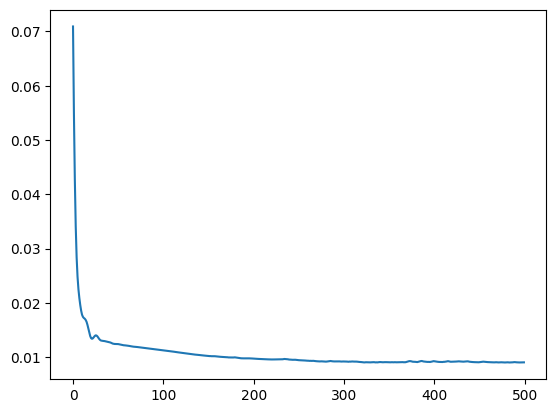

In [29]:
plt.plot(losses)

<ipython-input-32-f5bb4b2bed5a>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6, 6))


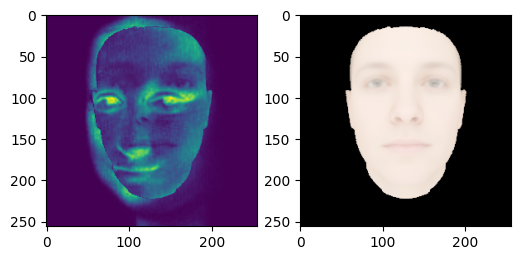

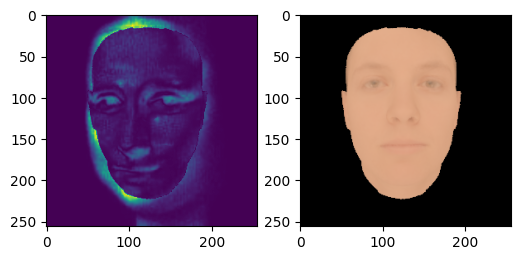

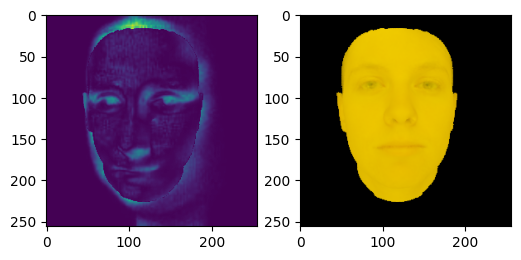

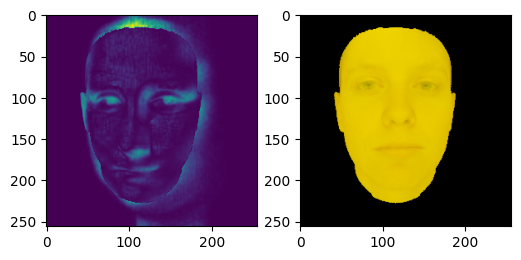

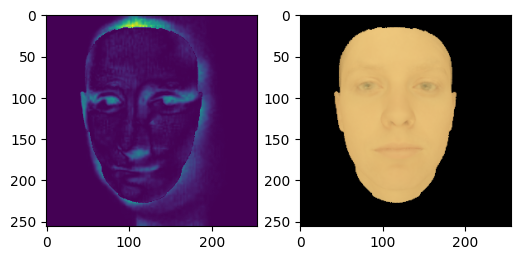

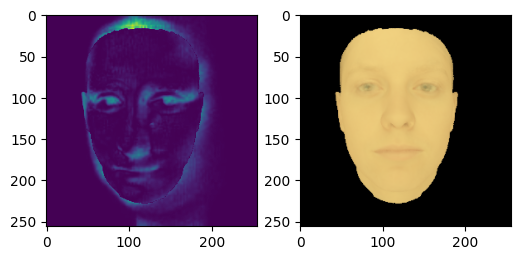

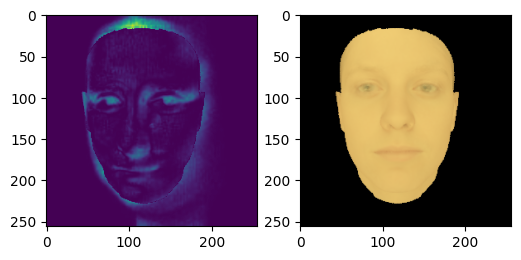

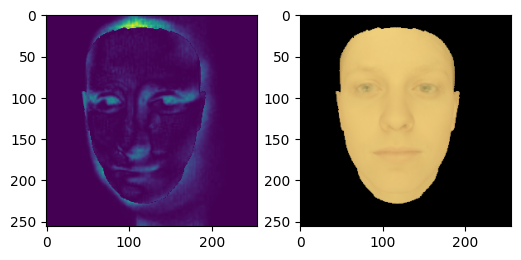

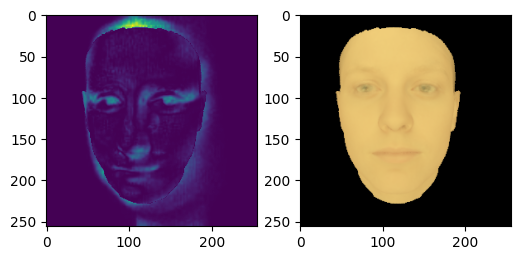

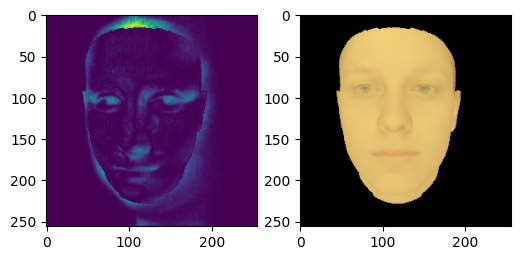

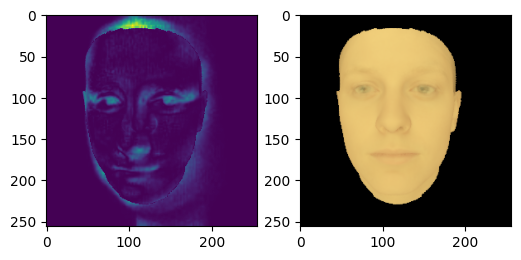

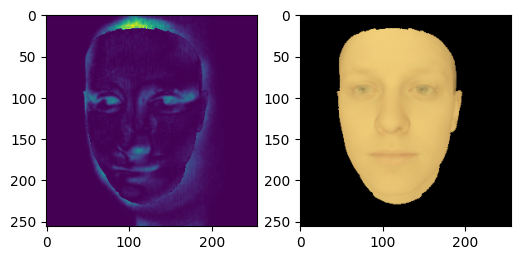

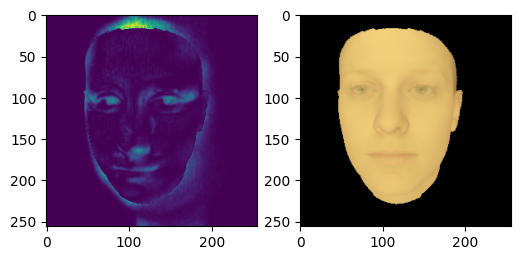

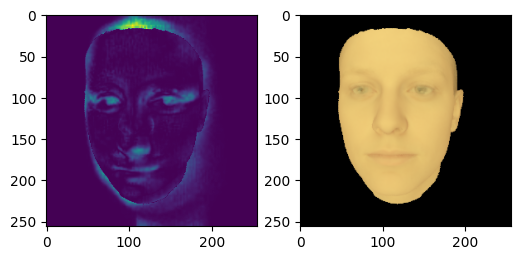

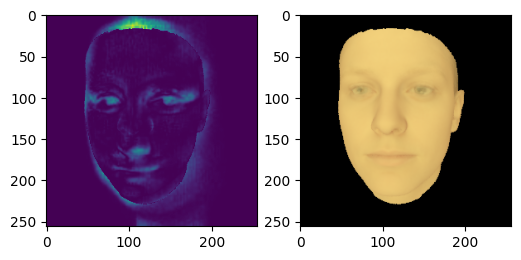

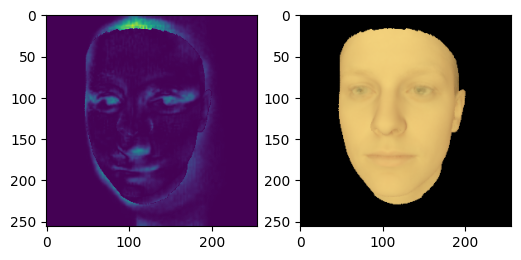

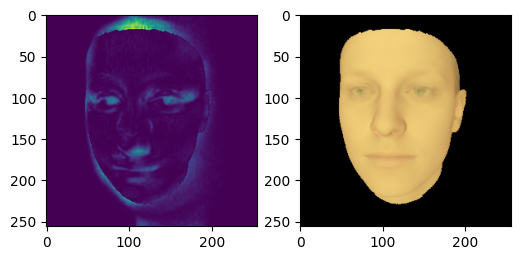

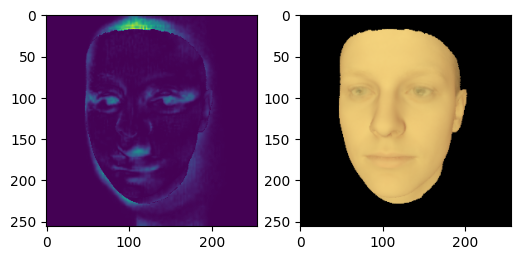

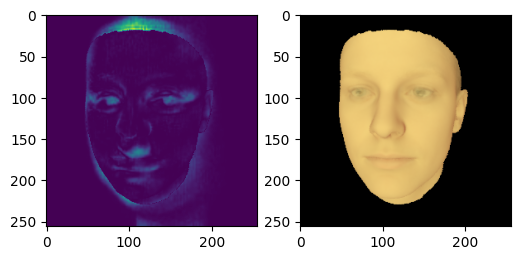

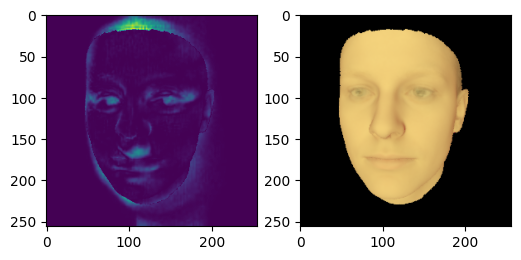

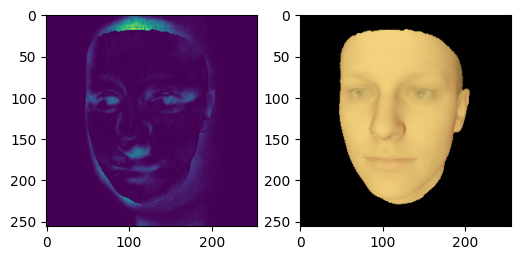

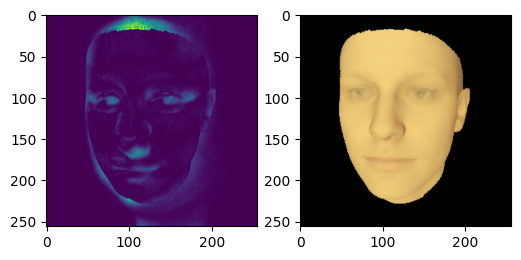

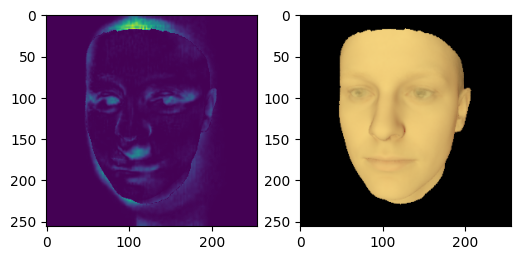

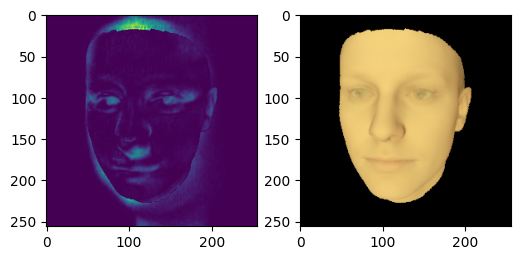

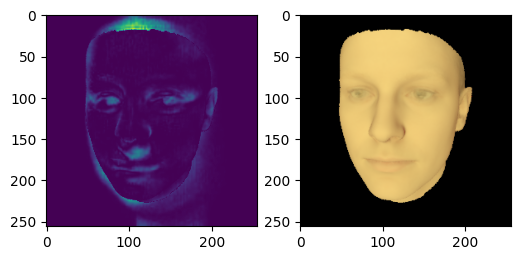

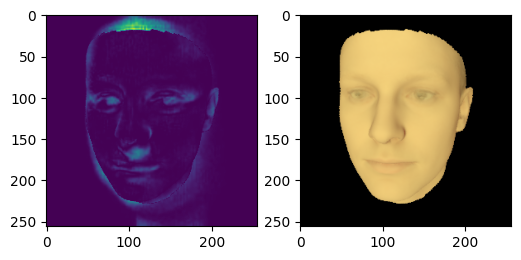

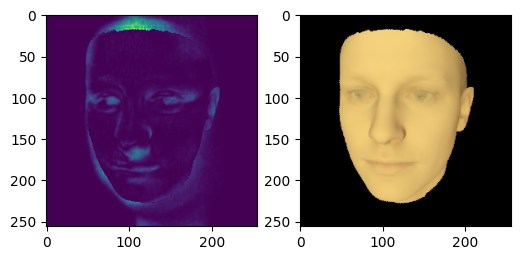

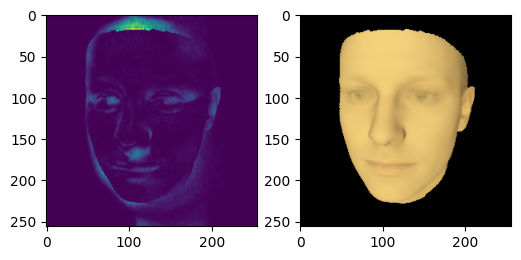

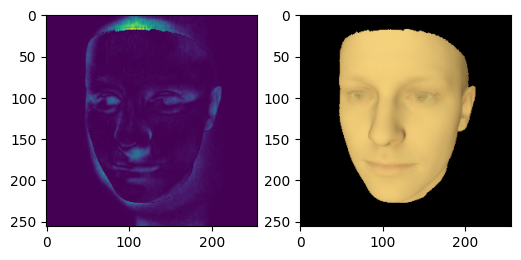

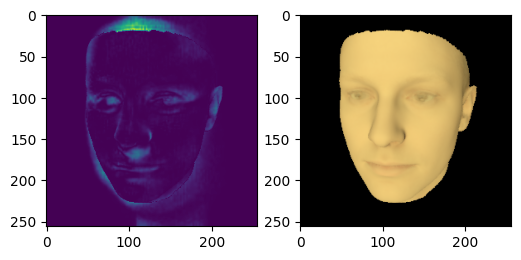

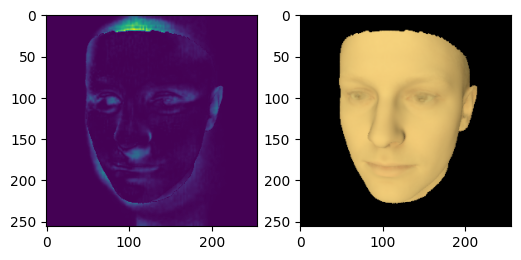

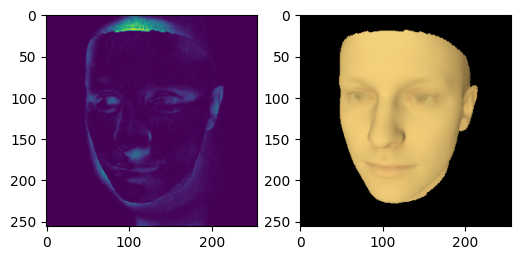

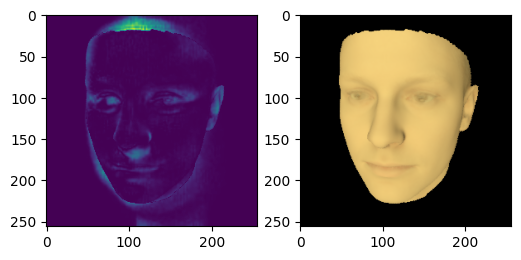

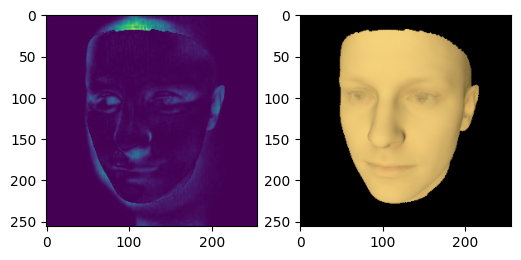

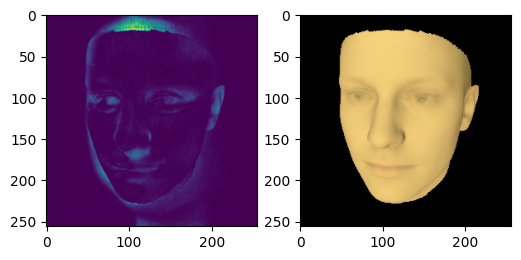

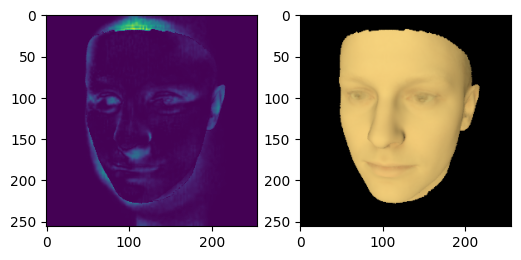

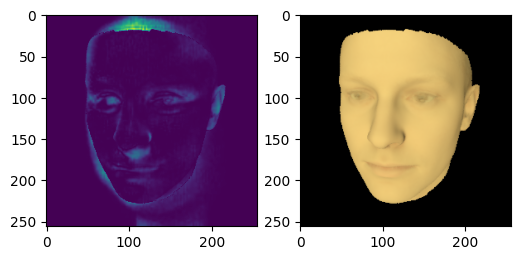

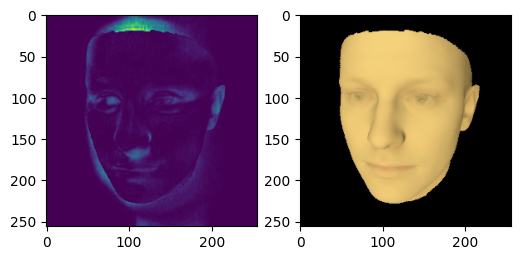

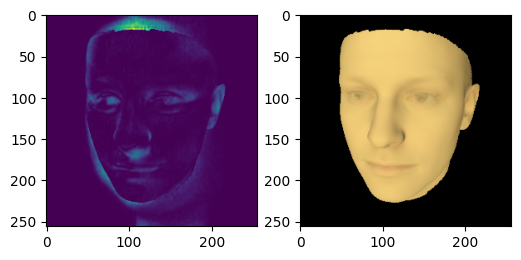

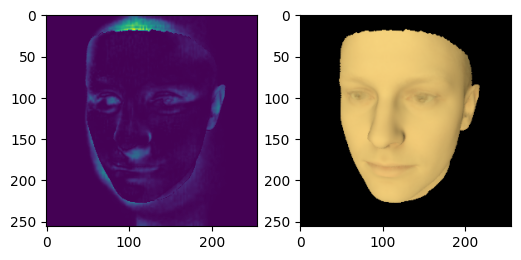

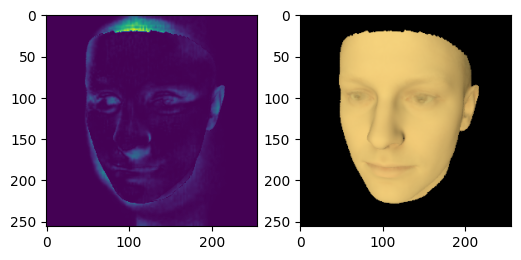

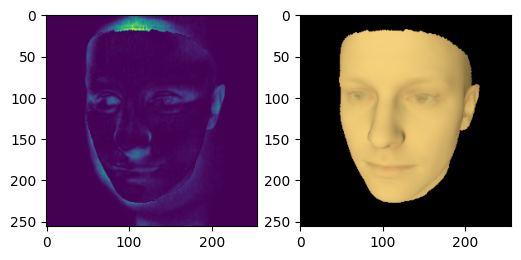

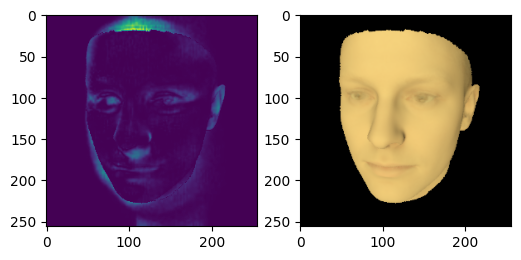

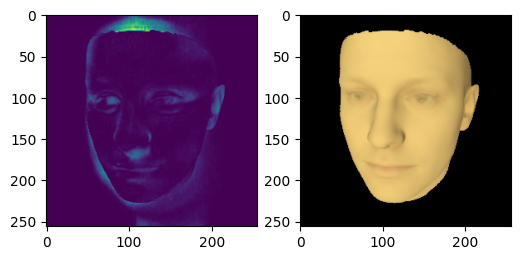

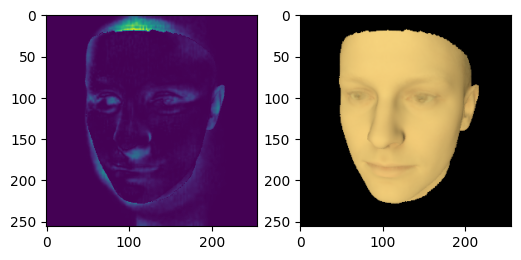

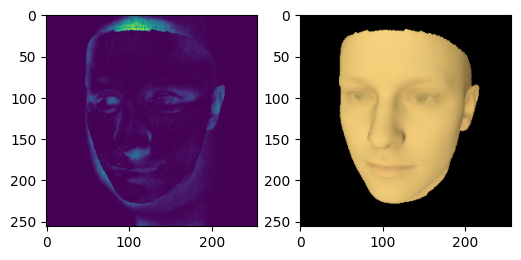

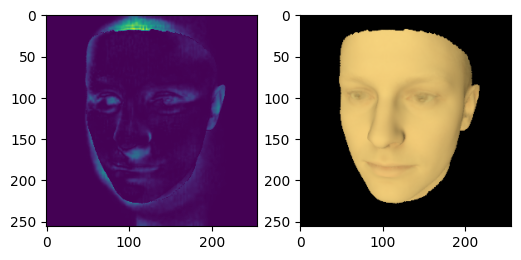

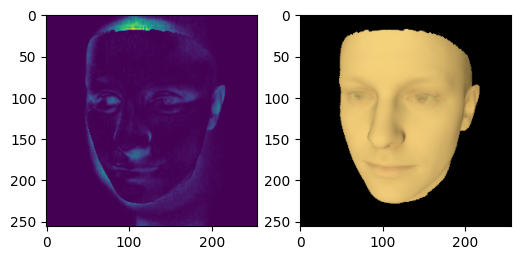

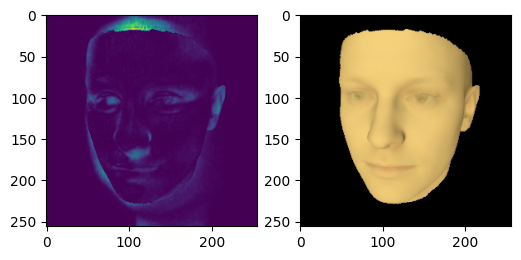

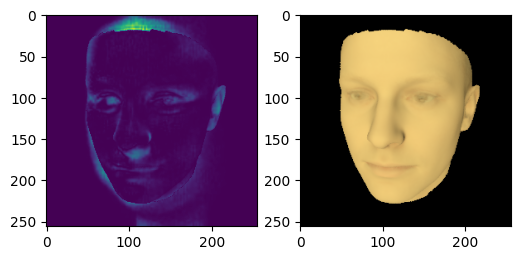

In [32]:
for img in imgs:
    fig = plt.figure(figsize=(6, 6))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow((img - target).pow(2).sum(dim=2).data.cpu())

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(torch.pow(img.data.cpu(), 1.0/2.2))

plt.show()